In [2]:
import hist
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from wremnants import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
import lz4.frame
import pickle
hep.style.use(hep.style.ROOT)

Welcome to JupyROOT 6.27/01


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
with lz4.frame.open("../w_z_gen_dists_slc7.pkl.lz4") as f:
    boost = pickle.load(f)

In [5]:
boost['dataPostVFP']['lumi']

16.807394938000005

In [6]:
def readForDataset(output, name, histname="nominal_gen"):
    if name not in output:
        raise ValueError(f"Sample {name} not in file")
    lumi = 1. if not "dataPostVFP" in output else output["dataPostVFP"]["lumi"]*1000
    info = output[name]
    scale = 1. if output[name]["dataset"]["is_data"] else \
                lumi*info["dataset"]["xsec"]/info["weight_sum"]
    print(scale)
    return info["output"][histname]*scale

In [7]:
def unrolledHist(h, obs=['prefsr_lepton_pt_gen', 'prefsr_lepton_eta_gen']):
    bins = np.multiply(*[len(a) for a in h.axes if a.name in obs])
    newh = hist.Hist(hist.axis.Regular(bins, 0, bins), storage=hist.storage.Weight())
    newh[...] = np.ravel(h.project(*obs))
    return newh

In [8]:
def makeVariationPlot(chns, variations, obs, xlabel, ylabel = 'Events/bin', 
                      rrange=[0.9, 1.1], scale=8.5e6):
    if type(variations) == str: variations = list(variations)
    width=3 if "unrolled" in obs else 1
    fig = plt.figure(figsize=(8*width,8))
    ax1 = fig.add_subplot(4, 1, (1, 3)) 
    ax2 = fig.add_subplot(4, 1, 4) 
    
    op = lambda x: x.project(obs) 
    if obs == "unrolled":
        op = unrolledHist

    hists  = [op(wgen[chn]['hist']['nominal']), *[op(wgen[chn]['hist']['vars'][x]) for x in variations]]
    colors = [wgen[chn]['color']['nominal'], *wgen[chn]['color']['vars']]
    labels = [wgen[chn]['label']['nominal'], *wgen[chn]['label']['vars']]
    
    hep.histplot(
        hists,
        histtype = "step",
        color = colors,
        label = labels,
        ax = ax1
    )
    

    hep.histplot(
        [hh.divideHists(x, hists[0]) for x in hists],
        histtype="step",
        yerr=False,
        color=colors,
        ax=ax2
    )
        
    ax1.set_xlabel("")
    ax2.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xticklabels([])
    xrange = [hists[0].axes[0].edges[0], hists[0].axes[0].edges[len(hists[0].axes[0])-1]]
    ax1.set_xlim(xrange)
    ax2.set_xlim(xrange)
    ax2.set_ylabel("variation/nominal", fontsize=22)
    ax2.set_ylim(rrange)
    ax1.set_ylim([0, scale])
    ax1.legend(prop={'size' : 20*(0.7 if width == 1 else 1.3)}, loc='upper right')

In [9]:
# comparing the same distribution in different sets of samples
# to figure out the effect of certain bug fixes

def makeComparisonPlot(chns, obs, xlabel, ylabel = 'Events/bin',
                       rrange=[0.9, 1.1], scale=8.5e6):
    if type(chns) == str: chns = list(chns)
    width=3 if "unrolled" in obs else 1
    fig = plt.figure(figsize=(8*width,8))
    ax1 = fig.add_subplot(4, 1, (1, 3)) 
    ax2 = fig.add_subplot(4, 1, 4) 
    
    op = lambda x: x.project(obs) 
    if obs == "unrolled":
        op = unrolledHist

    hists  = [op(wgen[chn]['hist']['nominal']) for chn in chns]
    colors = [wgen[chn]['color']['nominal'] for chn in chns]
    labels = [wgen[chn]['label']['nominal'] for chn in chns]
    
    hep.histplot(
        hists,
        histtype = "step",
        color = colors,
        label = labels,
        ax = ax1,
        binwnorm=True
    )
    

    hep.histplot(
        [hh.divideHists(x, hists[0]) for x in hists],
        histtype="step",
        yerr=False,
        color=colors,
        ax=ax2
    )
        
    ax1.set_xlabel("")
    ax2.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xticklabels([])
    xrange = [hists[0].axes[0].edges[0], hists[0].axes[0].edges[len(hists[0].axes[0])-1]]
    ax1.set_xlim(xrange)
    ax2.set_xlim(xrange)
    ax2.set_ylabel("variation/nominal", fontsize=22)
    ax2.set_ylim(rrange)
    ax1.set_ylim([0, scale])
    ax1.legend(prop={'size' : 20*(0.7 if width == 1 else 1.3)}, loc='upper right')

In [10]:
boost['ZmumuPostVFP_bugfix']['output']['helicity_moments_scale']

Hist(
  Regular(12, 60, 120, name='massVgen', label='massVgen'),
  Variable([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 10], name='absYVgen', label='absYVgen'),
  Regular(120, 0, 120, name='ptVgen', label='ptVgen'),
  Integer(0, 1, underflow=False, overflow=False, name='chargeVgen', label='chargeVgen'),
  Integer(-1, 8, underflow=False, overflow=False, name='helicity', label='helicity'),
  Variable([0.25, 0.75, 1.25, 2.75], underflow=False, overflow=False, name='muRfact', label='muRfact'),
  Variable([0.25, 0.75, 1.25, 2.75], underflow=False, overflow=False, name='muFfact', label='muFfact'),
  storage=Weight()) # Sum: WeightedSum(value=1.88974e+08, variance=7.62048e+08) (WeightedSum(value=1.98419e+08, variance=7.99857e+08) with flow)

In [11]:
boost['ZmumuPostVFP']['output']['helicity_moments_scale']

Hist(
  Regular(12, 60, 120, name='massVgen', label='massVgen'),
  Variable([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 10], name='absYVgen', label='absYVgen'),
  Regular(120, 0, 120, name='ptVgen', label='ptVgen'),
  Integer(0, 1, underflow=False, overflow=False, name='chargeVgen', label='chargeVgen'),
  Integer(-1, 8, underflow=False, overflow=False, name='helicity', label='helicity'),
  Variable([0.25, 0.75, 1.25, 2.75], underflow=False, overflow=False, name='muRfact', label='muRfact'),
  Variable([0.25, 0.75, 1.25, 2.75], underflow=False, overflow=False, name='muFfact', label='muFfact'),
  storage=Weight()) # Sum: WeightedSum(value=8.80093e+08, variance=3.19675e+09) (WeightedSum(value=9.23706e+08, variance=3.35377e+09) with flow)

In [12]:
boost['ZmumuPostVFP']['output']['helicity_moments_scale']

Hist(
  Regular(12, 60, 120, name='massVgen', label='massVgen'),
  Variable([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 10], name='absYVgen', label='absYVgen'),
  Regular(120, 0, 120, name='ptVgen', label='ptVgen'),
  Integer(0, 1, underflow=False, overflow=False, name='chargeVgen', label='chargeVgen'),
  Integer(-1, 8, underflow=False, overflow=False, name='helicity', label='helicity'),
  Variable([0.25, 0.75, 1.25, 2.75], underflow=False, overflow=False, name='muRfact', label='muRfact'),
  Variable([0.25, 0.75, 1.25, 2.75], underflow=False, overflow=False, name='muFfact', label='muFfact'),
  storage=Weight()) # Sum: WeightedSum(value=8.80093e+08, variance=3.19675e+09) (WeightedSum(value=9.23706e+08, variance=3.35377e+09) with flow)

In [13]:
boost['WplusmunuPostVFP']['output']['nominal_gen'].axes

(Variable([0, inf], name='massVgen', label='massVgen'),
 Variable([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 10], name='absYVgen', label='absYVgen'),
 Regular(120, 0, 120, name='ptVgen', label='ptVgen'),
 Regular(2, -2, 2, underflow=False, overflow=False, name='chargeVgen', label='chargeVgen'),
 Regular(48, -2.4, 2.4, name='prefsr_lepton_eta_gen', label='prefsr_lepton_eta_gen'),
 Regular(29, 26, 55, name='prefsr_lepton_pt_gen', label='prefsr_lepton_pt_gen'))

In [26]:
boost['WplusmunuPostVFP']['dataset']['xsec']

11572.19

In [33]:
boost['dataPostVFP']['lumi']

16.807394938000005

In [15]:
datagroups = {
    "Data" : dict(
        members = ["dataPostVFP"],
        color = "black",
        label = "Data",
        hist = {},
    ),
    "Fake" : dict(
        members = list(boost.keys()),
        label = "Nonprompt",
        color = "grey",
        hist = {},
    ),
    "Zmumu" : dict(
        members = ["ZmumuPostVFP"],
        label = r"Z$\to\mu\mu$",
        color = "lightblue",
        hist = {},
    ),   
    "Wtau" : dict(
        members = ["WminustaunuPostVFP", "WplustaunuPostVFP"],
        label = r"W$^{\pm}\to\tau\nu$",
        color = "orange",
        hist = {},
    ),
    "W" : dict(
        members = ["WminusmunuPostVFP", "WplusmunuPostVFP"],
        label = r"W$^{\pm}\to\mu\nu$",
        color = "darkred",
        hist = {},
    ),
    "Ztt" : dict(
        members = ["ZtautauPostVFP"],
        label = r"Z$\to\tau\tau$",
        color = "darkblue",
        hist = {},
    ), 
    "Top" : dict(
        members = ["TTSemileptonicPostVFP", "TTLeptonicPostVFP"],
        label = "Top",
        color = "green",
        hist = {},
    ), 
    "Diboson" : dict(
        members = ["WWPostVFP"],
        label = "Diboson",
        color = "pink",
        hist = {},
    ), 
}


variations = []
variation_labels = []
variation_colors = []

wgen = {
    'WminusmunuPostVFP': dict(
        label = {
            'nominal': r'$W^{-}$ nominal_gen',
            'vars': [r'$W^{-}$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'black',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    ),
    'WminusmunuPostVFP_bugfix': dict(
        label = {
            'nominal': r'$W^{-}$ nominal_gen bugfix',
            'vars': [r'$W^{-}$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'red',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    ),
    'WminusmunuPostVFP_bugfix_slc7': dict(
        label = {
            'nominal': r'$W^{-}$ nominal_gen bugfix slc7',
            'vars': [r'$W^{-}$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'green',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    ),
    'WplusmunuPostVFP': dict(
        label = {
            'nominal': r'$W^{+}$ nominal_gen',
            'vars': [r'$W^{+}$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'black',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    ),
    'WplusmunuPostVFP_bugfix': dict(
        label = {
            'nominal': r'$W^{+}$ nominal_gen bugfix',
            'vars': [r'$W^{+}$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'red',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    ),
    'ZmumuPostVFP': dict(
        label = {
            'nominal': r'$Z \rightarrow \mu\mu$ nominal_gen',
            'vars': [r'$Z \rightarrow \mu\mu$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'black',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    ),
    'ZmumuPostVFP_bugfix': dict(
        label = {
            'nominal': r'$Z \rightarrow \mu\mu$ nominal_gen bugfix',
            'vars': [r'$Z \rightarrow \mu\mu$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'red',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    )
}


for chn, v in wgen.items():
    try:
        h_nominal = readForDataset(boost, chn)
    except ValueError as e:
        print(e)
        continue
    v['hist']['nominal'] = h_nominal
#    v['hist']['nominal'] = sel.signalHistWmass(v['hist']['nominal'])
    
    for var in variations:
        try:
            h_var = readForDataset(boost, chn, histname = var)
        except ValueError as e:
            print(e)
            continue
        if 'pdf' in var:
            v['hist']['vars'][var] = h_var[...,1] #get the first var set after nominal
            v['hist']['vars'][var] = sel.signalHistWmass(v['hist']['vars'][var])
        elif 'qcd' in var:
            v['hist']['vars'][var] = h_var[...,0]
            v['hist']['vars'][var] = sel.signalHistWmass(v['hist']['vars'][var])
        elif 'muonScale' in var:
            v['hist']['vars'][var] = h_var[...,0,0] #[down, 2nd_eta_bin]
            v['hist']['vars'][var] = sel.signalHistWmass(v['hist']['vars'][var])
        elif 'massWeight' in var:
            v['hist']['vars'][var] = h_var[...,20] #for 100 MeV mass shift
            v['hist']['vars'][var] = sel.signalHistWmass(v['hist']['vars'][var])           

0.6837447275429979
12.095621967695516
6.299198350494592
0.5628931646478011
16.487577936466455
0.4444417893016192
2.037613450909335


In [16]:
#data
print(wgen['ZmumuPostVFP']['hist']['nominal'].sum())
print(wgen['ZmumuPostVFP_bugfix']['hist']['nominal'].sum())

WeightedSum(value=1.47137e+07, variance=7.51482e+06)
WeightedSum(value=1.4743e+07, variance=3.42253e+07)


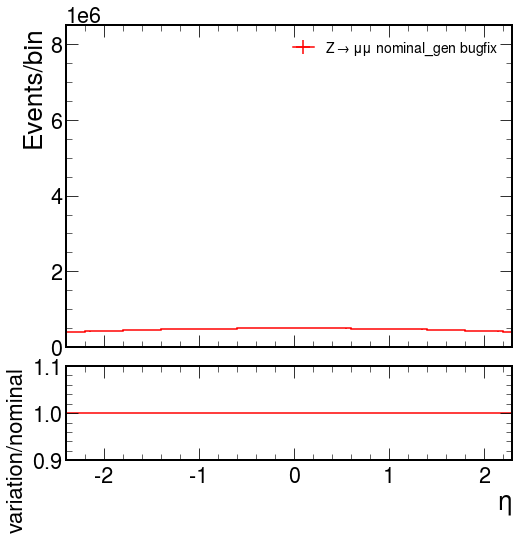

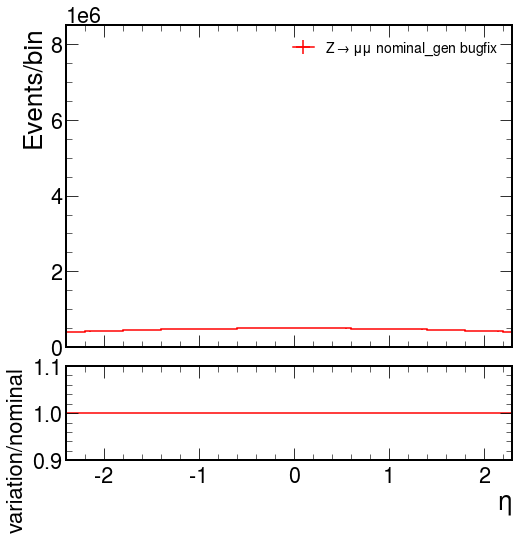

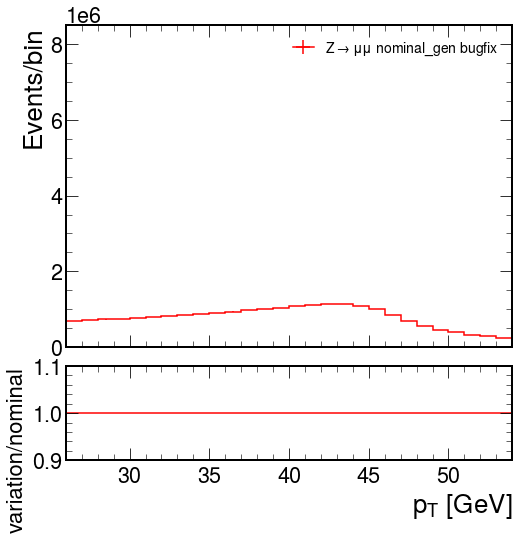

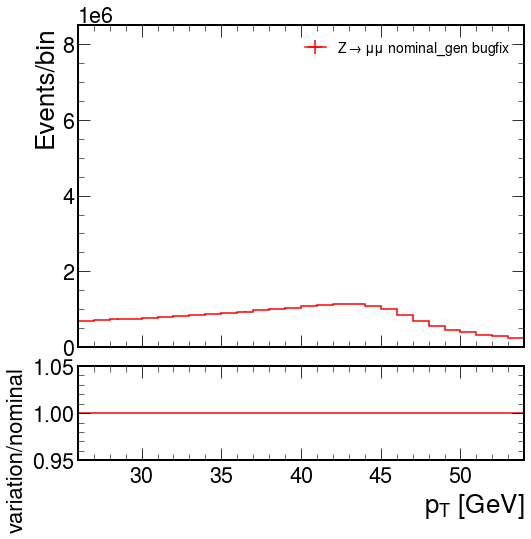

In [17]:
makeVariationPlot('WminusmunuPostVFP', variations, "prefsr_lepton_eta_gen", xlabel=r"$\eta$", rrange=[0.9, 1.1])
makeVariationPlot('WplusmunuPostVFP', variations, "prefsr_lepton_eta_gen", xlabel=r"$\eta$", rrange=[0.9, 1.1])
makeVariationPlot('WminusmunuPostVFP', variations, "prefsr_lepton_pt_gen", xlabel=r"p$_{T}$ [GeV]", rrange=[0.9, 1.1])
makeVariationPlot('WplusmunuPostVFP', variations, "prefsr_lepton_pt_gen", xlabel=r"p$_{T}$ [GeV]", rrange=[0.95, 1.05])


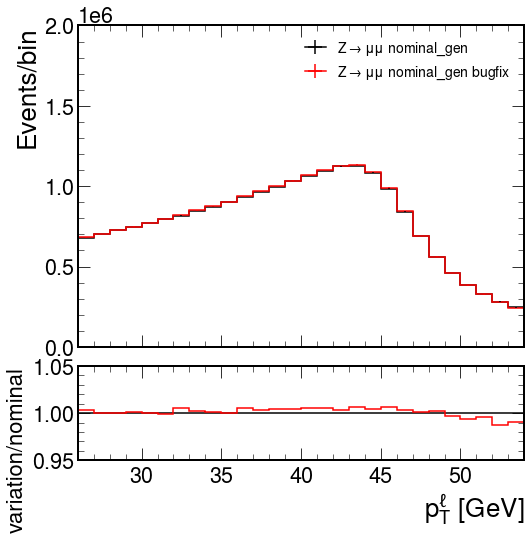

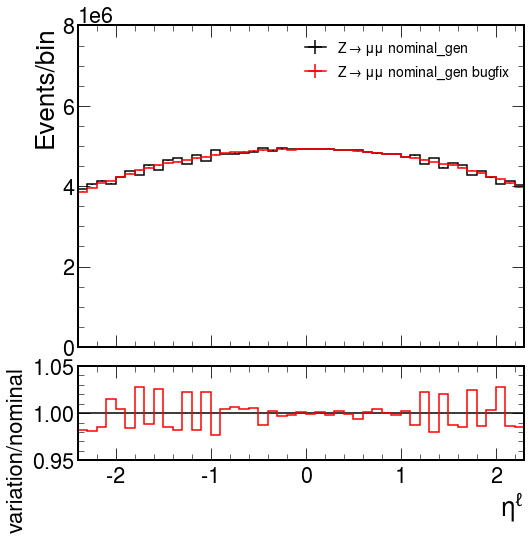

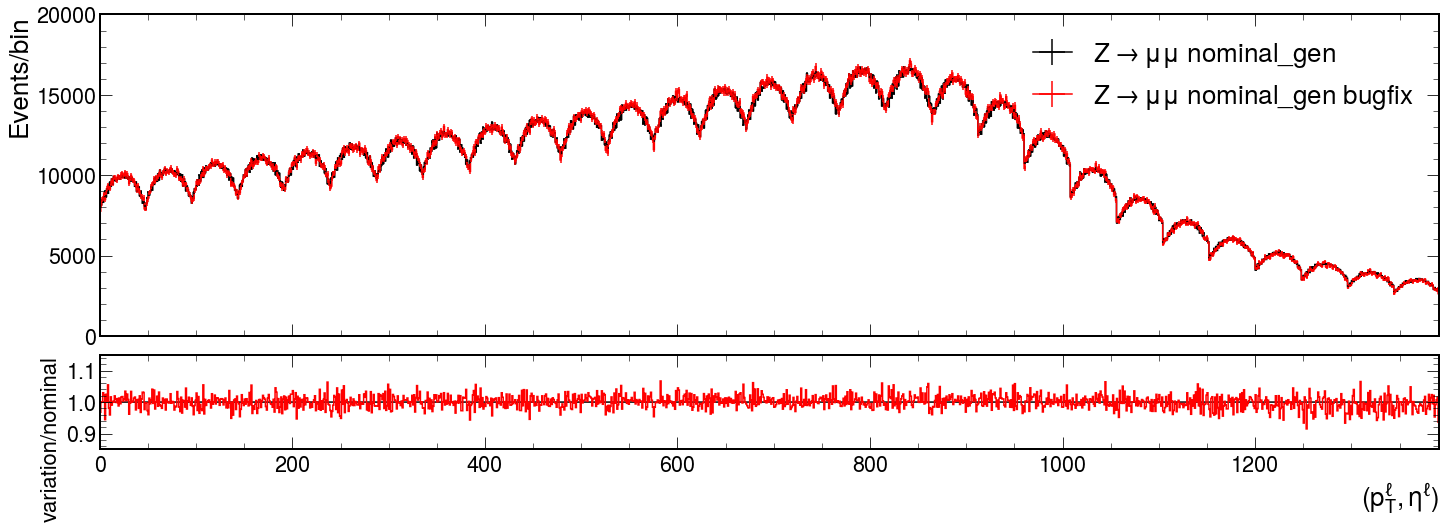

In [18]:
makeComparisonPlot(['ZmumuPostVFP', 'ZmumuPostVFP_bugfix'], "prefsr_lepton_pt_gen", xlabel=r"p$_{T}^{\ell}$ [GeV]" , rrange=[0.95, 1.05], scale=2e6)
makeComparisonPlot(['ZmumuPostVFP', 'ZmumuPostVFP_bugfix'], "prefsr_lepton_eta_gen", xlabel=r"$\eta^{\ell}$" , rrange=[0.95, 1.05], scale=8e6)
makeComparisonPlot(['ZmumuPostVFP', 'ZmumuPostVFP_bugfix'], "unrolled", xlabel=r"$(p_{T}^{\ell},\eta^{\ell})$" , rrange=[0.85, 1.15], scale=2e4)

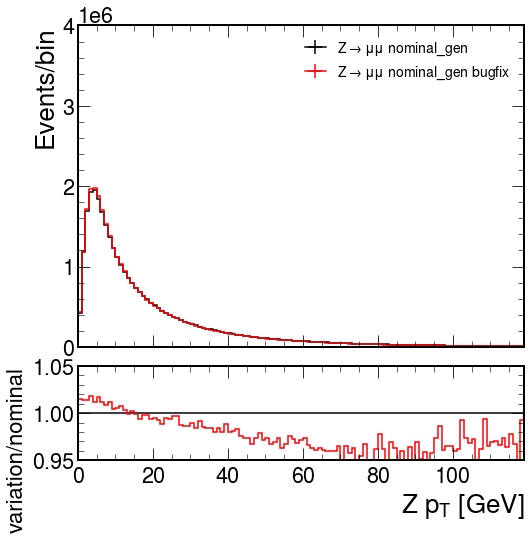

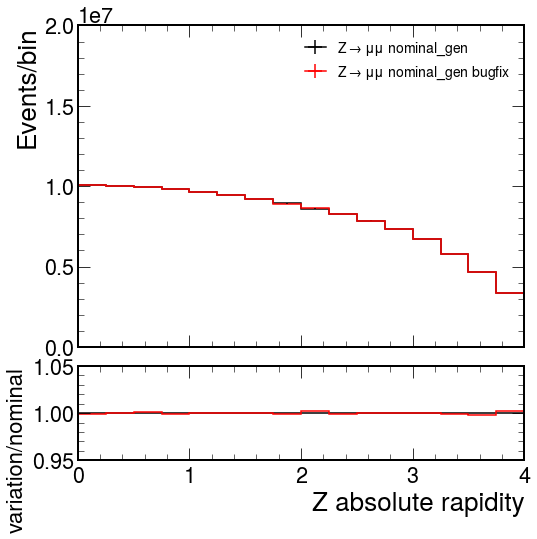

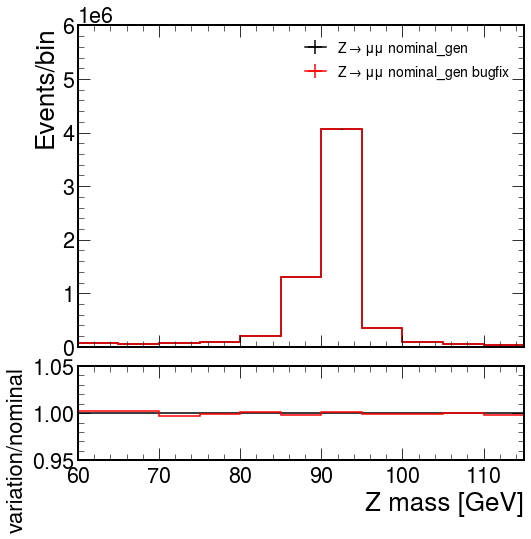

In [19]:
makeComparisonPlot(['ZmumuPostVFP', 'ZmumuPostVFP_bugfix'], "ptVgen", xlabel=r"Z p$_{T}$ [GeV]" , rrange=[0.95, 1.05], scale=4e6)
makeComparisonPlot(['ZmumuPostVFP', 'ZmumuPostVFP_bugfix'], "absYVgen", xlabel=r"Z absolute rapidity", rrange=[0.95, 1.05], scale=2e7)
makeComparisonPlot(['ZmumuPostVFP', 'ZmumuPostVFP_bugfix'], "massVgen", xlabel=r"Z mass [GeV]" , rrange=[0.95, 1.05], scale=6e6)

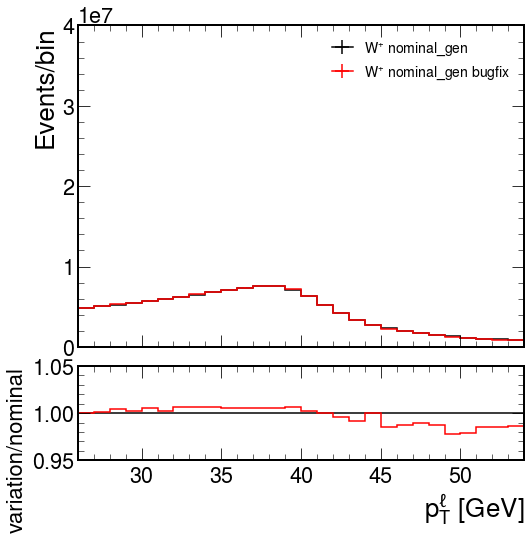

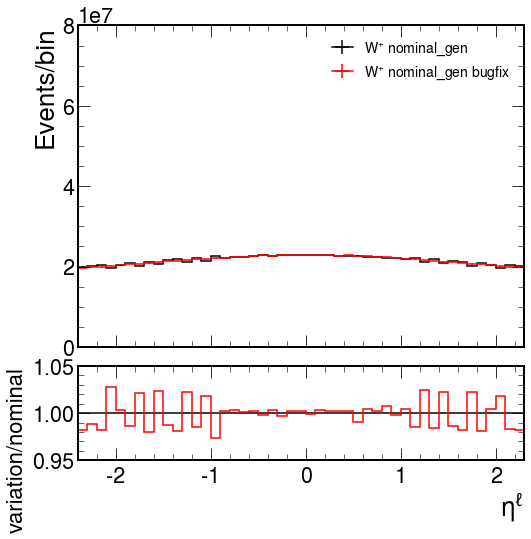

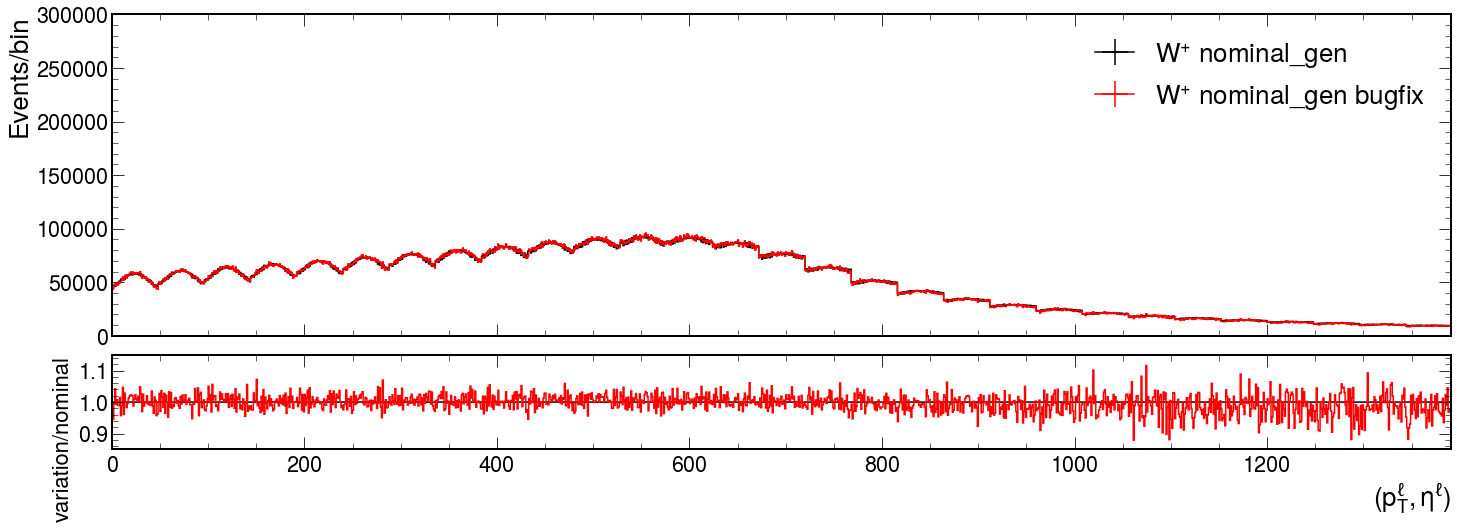

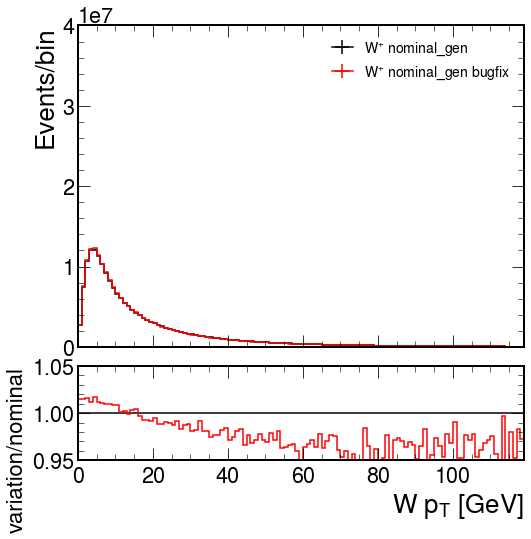

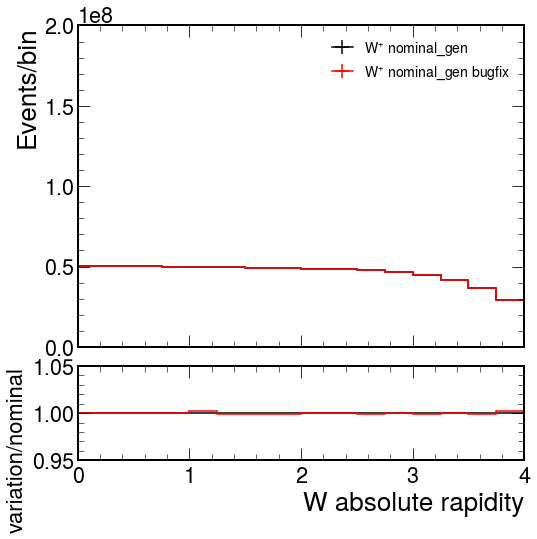

In [20]:
makeComparisonPlot(['WplusmunuPostVFP', 'WplusmunuPostVFP_bugfix'], "prefsr_lepton_pt_gen", xlabel=r"p$_{T}^{\ell}$ [GeV]" , rrange=[0.95, 1.05], scale=4e7)
makeComparisonPlot(['WplusmunuPostVFP', 'WplusmunuPostVFP_bugfix'], "prefsr_lepton_eta_gen", xlabel=r"$\eta^{\ell}$" , rrange=[0.95, 1.05], scale=8e7)
makeComparisonPlot(['WplusmunuPostVFP', 'WplusmunuPostVFP_bugfix'], "unrolled", xlabel=r"$(p_{T}^{\ell},\eta^{\ell})$" , rrange=[0.85, 1.15], scale=3e5)
makeComparisonPlot(['WplusmunuPostVFP', 'WplusmunuPostVFP_bugfix'], "ptVgen", xlabel=r"W p$_{T}$ [GeV]" , rrange=[0.95, 1.05], scale=4e7)
makeComparisonPlot(['WplusmunuPostVFP', 'WplusmunuPostVFP_bugfix'], "absYVgen", xlabel=r"W absolute rapidity", rrange=[0.95, 1.05], scale=2e8)
#makeComparisonPlot(['WplusmunuPostVFP', 'WplusmunuPostVFP_bugfix'], "massVgen", xlabel=r"Z mass [GeV]" , rrange=[0.95, 1.05], scale=6e6)

AttributeError: 'NoneType' object has no attribute 'savefig'

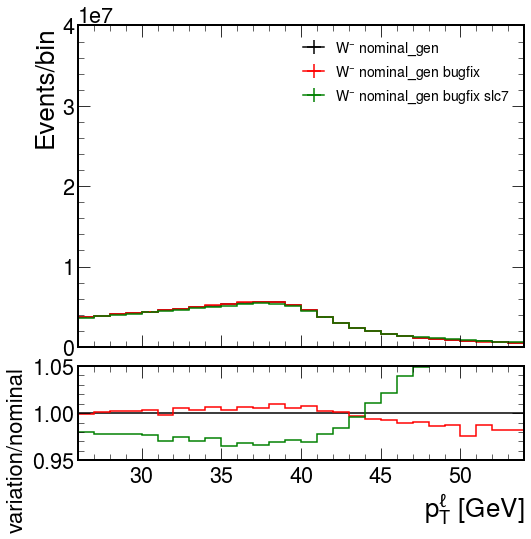

In [21]:
fig = makeComparisonPlot(['WminusmunuPostVFP', 'WminusmunuPostVFP_bugfix', 'WminusmunuPostVFP_bugfix_slc7'], "prefsr_lepton_pt_gen", xlabel=r"p$_{T}^{\ell}$ [GeV]" , rrange=[0.95, 1.05], scale=4e7)
fig.savefig("kinematics_lepton_pta.pdf")
fig.savefig("kinematics_lepton_pta.png")
fig = makeComparisonPlot(['WminusmunuPostVFP', 'WminusmunuPostVFP_bugfix', 'WminusmunuPostVFP_bugfix_slc7'], "prefsr_lepton_eta_gen", xlabel=r"$\eta^{\ell}$" , rrange=[0.95, 1.05], scale=8e7)
fig = makeComparisonPlot(['WminusmunuPostVFP', 'WminusmunuPostVFP_bugfix', 'WminusmunuPostVFP_bugfix_slc7'], "unrolled", xlabel=r"$(p_{T}^{\ell},\eta^{\ell})$" , rrange=[0.85, 1.15], scale=3e5)
fig = makeComparisonPlot(['WminusmunuPostVFP', 'WminusmunuPostVFP_bugfix', 'WminusmunuPostVFP_bugfix_slc7'], "ptVgen", xlabel=r"W p$_{T}$ [GeV]" , rrange=[0.95, 1.05], scale=4e7)
fig = makeComparisonPlot(['WminusmunuPostVFP', 'WminusmunuPostVFP_bugfix', 'WminusmunuPostVFP_bugfix_slc7'], "absYVgen", xlabel=r"W absolute rapidity", rrange=[0.95, 1.05], scale=2e8)

In [ ]:
with lz4.frame.open("../z_coeffs_bugged.pkl.lz4") as f:
    angcoeffs_z_bugged = pickle.load(f)
with lz4.frame.open("../z_coeffs_bugfix.pkl.lz4") as f:
    angcoeffs_z_bugfix = pickle.load(f)
with lz4.frame.open("../w_coeffs_bugged.pkl.lz4") as f:
    angcoeffs_w_bugged = pickle.load(f)
with lz4.frame.open("../w_coeffs_bugfix.pkl.lz4") as f:
    angcoeffs_w_bugfix = pickle.load(f)
print(angcoeffs_z_bugged.sum().value)
print(angcoeffs_z_bugfix.sum())
print(angcoeffs_w_bugfix.project("helicity"))

In [ ]:
#ang_lz4.keys()
hist_2d_angcoeffs_z_bugged = []
hist_2d_angcoeffs_z_bugfix = []
hist_2d_angcoeffs_wp_bugged = []
hist_2d_angcoeffs_wp_bugfix = []
hist_2d_angcoeffs_wm_bugged = []
hist_2d_angcoeffs_wm_bugfix = []

for i in range(0, 9):
    hist_2d_angcoeffs_z_bugged.append(angcoeffs_z_bugged[{"muRfact" : 1j, "muFfact" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_z_bugfix.append(angcoeffs_z_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wp_bugged.append(angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wp_bugfix.append(angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wm_bugged.append(angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : -1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wm_bugfix.append(angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : -1j, "helicity" : i}].project("ptVgen", "absYVgen"))

fig, axs = plt.subplots(3, 9, figsize=(72,24))
for i in range(0, 9):
#    weight_ratio_z  = hist_2d_angcoeffs_z_bugged[i].sum().value  / hist_2d_angcoeffs_z_bugfix[i].sum().value
#    weight_ratio_wp = hist_2d_angcoeffs_wp_bugged[i].sum().value / hist_2d_angcoeffs_wp_bugfix[i].sum().value
#    weight_ratio_wm = hist_2d_angcoeffs_wm_bugged[i].sum().value / hist_2d_angcoeffs_wm_bugfix[i].sum().value
    weight_ratio_z  = 1
    weight_ratio_wp = 1
    weight_ratio_wm = 1
    hh.divideHists(hist_2d_angcoeffs_z_bugfix[i]  * weight_ratio_z,  hist_2d_angcoeffs_z_bugged[i]) .plot(ax = axs[0,i])
    hh.divideHists(hist_2d_angcoeffs_wp_bugfix[i] * weight_ratio_wp, hist_2d_angcoeffs_wp_bugged[i]).plot(ax = axs[1,i])
    hh.divideHists(hist_2d_angcoeffs_wm_bugfix[i] * weight_ratio_wm, hist_2d_angcoeffs_wm_bugged[i]).plot(ax = axs[2,i])
    if i == 0:
        axs[0,i].set_title("Ratio of bugfix/bugged Const. term for Z")
        axs[1,i].set_title("Ratio of bugfix/bugged Const. term for W+")
        axs[2,i].set_title("Ratio of bugfix/bugged Const. term for W-")
    else:
        axs[0,i].set_title(f"Ratio of bugfix/bugged A_{i-1} for Z")
        axs[1,i].set_title(f"Ratio of bugfix/bugged A_{i-1} for W+")
        axs[2,i].set_title(f"Ratio of bugfix/bugged A_{i-1} for W-")
fig.tight_layout()
fig.savefig('ratio_ang_coeffs.pdf')


In [ ]:
ang_lz4[{"muRfact" : 1.j, "muFfact" : 1.j, "helicity" : 0}].project("ptVgen", "absYVgen").plot()


In [ ]:
print([i for i in range(1,5)])

In [ ]:
angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : 1j, "ptVgen":4j, "absYVgen": 0j}].values()


In [ ]:
angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : 1j, "ptVgen":4j, "absYVgen": 0j}].values()

In [ ]:
angcoeff_ratios_1d_Z  = []
angcoeff_ratios_1d_wp = []
angcoeff_ratios_1d_wm = []
fig, axs = plt.subplots(3, 6, figsize=(48,24))
fig.suptitle(r'ratio of angular coefficients for $|Y_V|= 0$ and $m_Z = 91 GeV$', fontsize = 60)
for i in range(0,6):
    angcoeff_ratios_1d_Z .append(angcoeffs_z_bugged[{"muRfact" : 1j, "muFfact" : 1j, "ptVgen":i, "absYVgen": 0j, "massVgen":  91j}].values()/angcoeffs_z_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "ptVgen":i, "absYVgen": 0j, "massVgen":  91j}].values())
    angcoeff_ratios_1d_wp.append(angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "ptVgen":i, "absYVgen": 0j, "chargeVgen": 1j}].values()/angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "ptVgen":i, "absYVgen": 0j, "chargeVgen": 1j}].values())
    angcoeff_ratios_1d_wm.append(angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "ptVgen":i, "absYVgen": 0j, "chargeVgen":-1j}].values()/angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "ptVgen":i, "absYVgen": 0j, "chargeVgen":-1j}].values())
    
for i in range(0,6):
    axs[0,i].plot(range(-1,8), angcoeff_ratios_1d_Z[i].flatten(), yerr=True)
    pt_range = angcoeffs_z_bugged.axes["ptVgen"].edges[i:i+2]
    axs[0,i].set_xlabel("ang. coeff.")
    axs[0,i].set_ylabel("bugfix/bugged")
    axs[0,i].set_title(f"ptZ = {pt_range[0]} - {pt_range[1]} GeV")
    axs[1,i].plot(range(-1,8), angcoeff_ratios_1d_wp[i].flatten(), yerr=True)
    pt_range = angcoeffs_w_bugged.axes["ptVgen"].edges[i:i+2]
    axs[1,i].set_xlabel("ang. coeff.")
    axs[1,i].set_ylabel("bugfix/bugged")
    axs[1,i].set_title(f"ptW+ = {pt_range[0]} - {pt_range[1]} GeV")  
    axs[2,i].plot(range(-1,8), angcoeff_ratios_1d_wm[i].flatten(), yerr=True)
    pt_range = angcoeffs_w_bugged.axes["ptVgen"].edges[i:i+2]
    axs[2,i].set_xlabel("ang. coeff.")
    axs[2,i].set_ylabel("bugfix/bugged")
    axs[2,i].set_title(f"ptW- = {pt_range[0]} - {pt_range[1]} GeV")
fig.tight_layout()
fig.savefig('1dangcoeff.pdf')

In [ ]:
plt.plot(range(-1,8), angcoeff_ratios.flatten())
plt.xlabel("angular coefficients for ptV = 4 GeV, etaV = 0")
plt.ylabel("bugged/bugfix")

In [ ]:
angcoeffs_z_bugged.axes["ptVgen"].edges

In [ ]:
#ang_lz4.keys()
hist_2d_angcoeffs_z_bugged = []
hist_2d_angcoeffs_z_bugfix = []
hist_2d_angcoeffs_wp_bugged = []
hist_2d_angcoeffs_wp_bugfix = []
hist_2d_angcoeffs_wm_bugged = []
hist_2d_angcoeffs_wm_bugfix = []

for i in range(0, 9):
    hist_2d_angcoeffs_z_bugged.append(angcoeffs_z_bugged[{"muRfact" : 1j, "muFfact" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_z_bugfix.append(angcoeffs_z_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wp_bugged.append(angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wp_bugfix.append(angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wm_bugged.append(angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : -1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wm_bugfix.append(angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : -1j, "helicity" : i}].project("ptVgen", "absYVgen"))

fig, axs = plt.subplots(3, 9, figsize=(72,24))
for i in range(0, 9):
#    weight_ratio_z  = hist_2d_angcoeffs_z_bugged[i].sum().value  / hist_2d_angcoeffs_z_bugfix[i].sum().value
#    weight_ratio_wp = hist_2d_angcoeffs_wp_bugged[i].sum().value / hist_2d_angcoeffs_wp_bugfix[i].sum().value
#    weight_ratio_wm = hist_2d_angcoeffs_wm_bugged[i].sum().value / hist_2d_angcoeffs_wm_bugfix[i].sum().value
    weight_ratio_z  = 1
    weight_ratio_wp = 1
    weight_ratio_wm = 1
    hist_2d_angcoeffs_z_bugged[i] .plot(ax = axs[0,i])
    hist_2d_angcoeffs_wp_bugged[i].plot(ax = axs[1,i])
    hist_2d_angcoeffs_wm_bugged[i].plot(ax = axs[2,i])
    if i == 0:
        axs[0,i].set_title("bugged Const. term for Z")
        axs[1,i].set_title("bugged Const. term for W+")
        axs[2,i].set_title("bugged Const. term for W-")
    else:
        axs[0,i].set_title(f"bugged A_{i-1} for Z")
        axs[1,i].set_title(f"bugged A_{i-1} for W+")
        axs[2,i].set_title(f"bugged A_{i-1} for W-")
fig.tight_layout()
fig.savefig('bugged_ang_coeffs.pdf')

In [ ]:
#ang_lz4.keys()
hist_2d_angcoeffs_z_bugged = []
hist_2d_angcoeffs_z_bugfix = []
hist_2d_angcoeffs_wp_bugged = []
hist_2d_angcoeffs_wp_bugfix = []
hist_2d_angcoeffs_wm_bugged = []
hist_2d_angcoeffs_wm_bugfix = []

for i in range(0, 9):
    hist_2d_angcoeffs_z_bugged.append(angcoeffs_z_bugged[{"muRfact" : 1j, "muFfact" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_z_bugfix.append(angcoeffs_z_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wp_bugged.append(angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wp_bugfix.append(angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : 1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wm_bugged.append(angcoeffs_w_bugged[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : -1j, "helicity" : i}].project("ptVgen", "absYVgen"))
    hist_2d_angcoeffs_wm_bugfix.append(angcoeffs_w_bugfix[{"muRfact" : 1j, "muFfact" : 1j, "chargeVgen" : -1j, "helicity" : i}].project("ptVgen", "absYVgen"))

fig, axs = plt.subplots(3, 9, figsize=(72,24))
for i in range(0, 9):
#    weight_ratio_z  = hist_2d_angcoeffs_z_bugged[i].sum().value  / hist_2d_angcoeffs_z_bugfix[i].sum().value
#    weight_ratio_wp = hist_2d_angcoeffs_wp_bugged[i].sum().value / hist_2d_angcoeffs_wp_bugfix[i].sum().value
#    weight_ratio_wm = hist_2d_angcoeffs_wm_bugged[i].sum().value / hist_2d_angcoeffs_wm_bugfix[i].sum().value
    weight_ratio_z  = 1
    weight_ratio_wp = 1
    weight_ratio_wm = 1
    hist_2d_angcoeffs_z_bugfix[i] .plot(ax = axs[0,i])
    hist_2d_angcoeffs_wp_bugfix[i].plot(ax = axs[1,i])
    hist_2d_angcoeffs_wm_bugfix[i].plot(ax = axs[2,i])
    if i == 0:
        axs[0,i].set_title("bugfix Const. term for Z")
        axs[1,i].set_title("bugfix Const. term for W+")
        axs[2,i].set_title("bugfix Const. term for W-")
    else:
        axs[0,i].set_title(f"bugfix A_{i-1} for Z")
        axs[1,i].set_title(f"bugfix A_{i-1} for W+")
        axs[2,i].set_title(f"bugfix A_{i-1} for W-")
fig.tight_layout()
fig.savefig('bugfix_ang_coeffs.pdf')